# **Explore xView dataset**

In [1]:
import os

# MAKE SURE TO USE CONDA LOCALLY
#!pip install rasterio
#!pip install geopandas
#!pip install rioxarray

import rasterio as rio
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.mask import mask
import geopandas as gpd
import rioxarray as rxr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 6.1 MB/s eta 0:00:0000:0100:01


**Mount to Google Drive**

When using Google colab, use drive from google.colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

When using a local machine, use PyDrive2. We will do this later once all the files are condensed and filter for hurricanes. For now please use colab <3

Code to use later on: (from https://medium.com/@zakriya57/integrating-google-drive-in-your-application-1c3012fef396)

! pip install PyDrive2

from pydrive2.auth import GoogleAuth

from pydrive2.drive import GoogleDrive

gauth = GoogleAuth()

gauth.LocalWebserverAuth()

**Access Github**

Tutorial on Github and Google drive: https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

xBD data is mounted in the drive but remember to put those into the gitignore when trying to push!

In [3]:
%cd /content/drive/MyDrive/hurricane-harm-herald

/content/drive/MyDrive/hurricane-harm-herald


In [4]:
!git pull

Already up to date.


In [6]:
! git add notebooks/Explore_xView

Switched to a new branch 'notebooks'


In [ ]:
#!git clone https://KEY@github.com/ai4er-cdt/hurricane-harm-herald

Cloning into 'hurricane-harm-herald'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 35 (delta 11), reused 28 (delta 9), pack-reused 0
Unpacking objects: 100% (35/35), 5.28 KiB | 10.00 KiB/s, done.


**Access xBD data**

In [ ]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data

/content/drive/.shortcut-targets-by-id/1EHt_yqzxiWrRYIQhzPQArap653u3q0lw/hurricane-harm-herald/data/xBD_data


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1EHt_yqzxiWrRYIQhzPQArap653u3q0lw/hurricane-harm-herald/data/xBD_data


In [ ]:
# Do we really have to concatenat or can we just leave it separate? 
# I might concatenate only the files with hurricanes
# !cat xview2_geotiff.tgz.part-a? > xview2_geotiff.tgz

In [ ]:
# xView website asks to verify the integrity of each file by comparing SHA1 hashes
!shasum -a 1 xview2_geotiff.tgz.part-ad

44a39a7c4a80d386fb71ced95caee040126bb405  xview2_geotiff.tgz.part-ad


In [ ]:
# Have only opened the part-aa so far. Need to update Google One storage..
#!tar -xf xview2_geotiff.tgz.part-aa

Images are stored in /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/images/hurricane-florence_00000097_pre_disaster.tif and can thus be filtered by the 'hurricane' in the name

## **Open geotiff file**
Next step: write function that filters hurricane + post-damage label +  + pre-damage image

In [ ]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/images

/content/drive/.shortcut-targets-by-id/1EHt_yqzxiWrRYIQhzPQArap653u3q0lw/hurricane-harm-herald/data/xBD_data/geotiffs/hold/images


In [ ]:
tiff_link = "hurricane-florence_00000006_pre_disaster.tif"
data = rxr.open_rasterio(tiff_link)

In [ ]:
data

<xarray.DataArray (band: 3, y: 1024, x: 1024)>
[3145728 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 -79.04 -79.04 -79.04 ... -79.04 -79.04 -79.04
  * y            (y) float64 33.59 33.59 33.59 33.59 ... 33.58 33.58 33.58 33.58
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -99
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# check if 3 RGB bands/multispectral
len(rxr.open_rasterio(tiff_link)["band"])

3

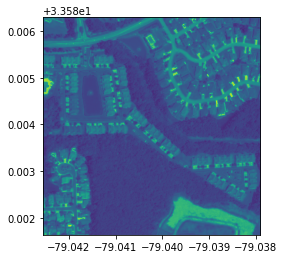

In [ ]:
import rasterio
from rasterio.plot import show
img = rasterio.open(tiff_link)
show(img)

In [ ]:
src = rio.open(tiff_link)
src.res # in degrees

(4.543162180757512e-06, 4.543162180757512e-06)

In [ ]:
# Alice's function
def convert_deg_to_meters(deg):
  import math
  earth_radius = 6371*10**(3)
  return (earth_radius*math.pi*deg)/180

tuple(map(convert_deg_to_meters, src.res))

(0.5051765854236651, 0.5051765854236651)

##**Open labelled JSON file**

In [ ]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels

/content/drive/.shortcut-targets-by-id/1EHt_yqzxiWrRYIQhzPQArap653u3q0lw/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels


In [ ]:
# find corresponding json link: see 00000006 and name
print(tiff_link)

hurricane-florence_00000006_pre_disaster.tif


In [ ]:
json_link = "hurricane-florence_00000014_post_disaster.json"

In [ ]:
import json
json_file = open(json_link)
json_data = json.load(json_file)

In [ ]:
import pandas as pd
import geopandas as gpd
nta = pd.read_json(json_link)

In [ ]:
!pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
with open('path_to_file/person.json', 'r') as f:
  data = json.load(f)

ERROR:fiona._env:`hurricane-florence_00000006_post_disaster.json' not recognized as a supported file format.


DriverError: ignored